# Build ALL the classifiers!

In this tutorial, we will throw all of the most common classifiers at the introvert problem!  Let's not worry too much about what each algorithm is doing. Instead, we will be focussing on how to tell which model is likely to better at solving this problem.  In this tutorial, you will fit the following classifiers to the Introvert / Extrovert dataset:
* Logistic Regression
* K Nearest Neighbours (KNN)
* Support Vector Machines (SVM)
* Naive Bayes
* LDA / QDA
* Decision Trees
* Neural Network

This approach highlights a key principle in machine learning.  The best models are built through **iteration**. We need to be able to implement a 'quick and dirty' solution that should give us a good idea of how to proceed in finding a solution to a particular problem.  The quicker we can get the an interation, the quicker we can come up with new ideas of how to proceed.

In the next tutorial, we will go further into KNN and SVM as we look at how to optimise model performance through the use of hyperparameters selection.

# Import ALL the models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

# to automate the NLP extraction...
from sklearn.feature_extraction.text import CountVectorizer

# Cross_val_score is the new class for today...
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

# main ones to focus on for this sprint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Covered in sprint 3
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Covered in sprint 4
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Neural Network!!
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import SGDClassifier

# Get and clean the data

You should be familiar with these steps from the previous tutorial on `Handling Text Data in Machine Learning`. Can you think of, and implement, additional data cleaning and optimisation steps to improve our classification model?

In [2]:
## read the data
mbti = pd.read_csv('train.csv')

## split the rows
all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

## remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_mbti['post'] = all_mbti['post'].replace(to_replace = pattern_url, value = subs_url, regex = True)

# make lower case
all_mbti['post'] = all_mbti['post'].str.lower()

#remove punctuation
import string
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
all_mbti['post'] = all_mbti['post'].apply(remove_punctuation_numbers)

We will only be looking at the Introvert / Extrovert dimension here.  Can you figure out how to use this script to build models for the different types? 

In [3]:
all_mbti['I'] = all_mbti['type'].apply(lambda x: x[0] == 'I').astype('int')

In [4]:
y = all_mbti['I']

In [5]:
y.shape

(316548,)

In [6]:
vect = CountVectorizer(stop_words='english', min_df= .01)
X = vect.fit_transform(all_mbti['post'])

In [7]:
type(X)

scipy.sparse.csr.csr_matrix

In [8]:
X.shape

(316548, 152)

In [9]:
# save the dataset for the next training document
pd_intro = pd.DataFrame(X.A, columns=vect.get_feature_names())
pd_intro['y'] = y
pd_intro.to_csv('introvert_mbti_count_vector.csv')

We have alot of training data here!  To speed the alogorithms up and illustrate the effects, we will alone be using the first 5,000 rows of data.  Please play around with this n to get a feel of how each algorithm responds to more data (from an accuracy and training time point of view)

In [10]:
n = 5000
X_train, X_test, y_train, y_test = train_test_split(X[:n].toarray(), y[:n])

In [11]:
# if we assume that everyone is introverted would give us this accuracy
np.mean(y_train)

0.8018666666666666

# Lets build ALL the classification models!

In the next two cells, we will define the model names and call the model implementation classes. Note how some of the classifiers need input variables.  These are examples of **hyperparameters**. Don't worry too much about this for now, we will be covering hyperparameter selection in the next tutorial.

In [12]:
names = ['Logistic Regression', 
         'Nearest Neighbors', 
         'Linear SVM', 
         'RBF SVM', 
         'Naive Bayes', 
         'LDA', 
         "QDA",          
         "Decision Tree", 
         "Random Forest",  
         "AdaBoost", 
         "Neural Net",
         'hingeSGDC', 
         'logSGDC']

In [13]:
classifiers = [
    LogisticRegression(), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),    
    GaussianNB(),    
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),    
    
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier(),
    
    MLPClassifier(alpha=1),
    
    SGDClassifier(class_weight='balanced'),    
    SGDClassifier(loss='log', class_weight='balanced')
]

While this is running see if you can tell which algorithm was the longest to train 

In [14]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)
    
    f1        = metrics.f1_score(y_train, y_pred)    
    f1_test   = metrics.f1_score(y_test, y_pred_test)    
    
    # save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...


C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


... predicting
... scoring
Fitting Naive Bayes model...
... predicting
... scoring
Fitting LDA model...
... predicting
... scoring
Fitting QDA model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...


C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


... predicting
... scoring
Fitting Neural Net model...
... predicting
... scoring


C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1]:
results.sort_values('F1 Test', ascending=False)

NameError: name 'results' is not defined

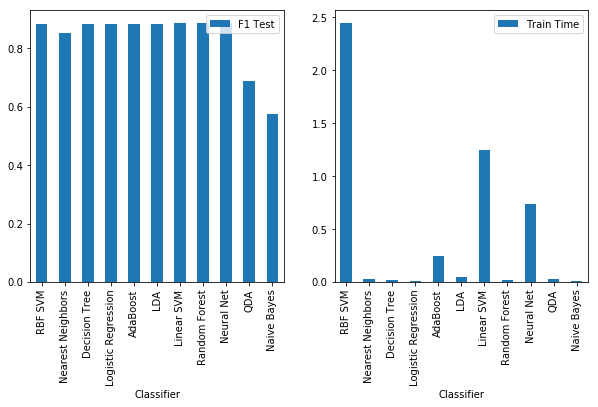

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1])
results.plot(y='Train Time', kind='bar', ax=ax[1])

In [17]:
confusion['Logistic Regression']

array([[  21,  722],
       [  11, 2996]], dtype=int64)

In [18]:
confusion['RBF SVM']

array([[ 583,  160],
       [  10, 2997]], dtype=int64)

In [19]:
print(class_report['RBF SVM'])

             precision    recall  f1-score   support

          0       0.98      0.78      0.87       743
          1       0.95      1.00      0.97      3007

avg / total       0.96      0.95      0.95      3750



# Model Validation

But how do we know if these models are robust?  Model validation is the process of checking if our model produces reliable results. In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

In the rest of this tutorial, we consider a common approach to validation called`k folds`. In its simpliest form, k_folds fits a single model to a number of different versions of the test_train_split and compares how volatile the results of the model are. 

## [K_Folds Cross Validation](https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/)

That's where [K Folds cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) comes in.

[![K-Fold Cross Validation](http://img.youtube.com/vi/TIgfjmp-4BA/0.jpg)](https://www.youtube.com/watch?v=TIgfjmp-4BA)

In python, [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) is easily implemented in SKLearn

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
model = models['Logistic Regression']
print(cross_val_score(model, X[:n].toarray(), y[:n]))

[ 0.79736211  0.78451381  0.79471789]


In [22]:
cv = []
for name, model in models.items():
    print(name)
    scores = cross_val_score(model, X=X[:n].toarray(), y=y[:n], cv=10)
    print("Accuracy: {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std()))
    cv.append([name, scores.mean(), scores.std() ])
    
cv = pd.DataFrame(cv, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cv.set_index('Model', inplace=True)

Logistic Regression
Accuracy: 0.80 (+/- 0.01)
Nearest Neighbors
Accuracy: 0.72 (+/- 0.02)
Linear SVM
Accuracy: 0.80 (+/- 0.00)
RBF SVM
Accuracy: 0.80 (+/- 0.01)
Naive Bayes
Accuracy: 0.47 (+/- 0.05)
LDA
Accuracy: 0.79 (+/- 0.01)
QDA


C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.53 (+/- 0.08)
Decision Tree
Accuracy: 0.79 (+/- 0.00)
Random Forest
Accuracy: 0.80 (+/- 0.00)
AdaBoost
Accuracy: 0.79 (+/- 0.00)
Neural Net
Accuracy: 0.80 (+/- 0.00)


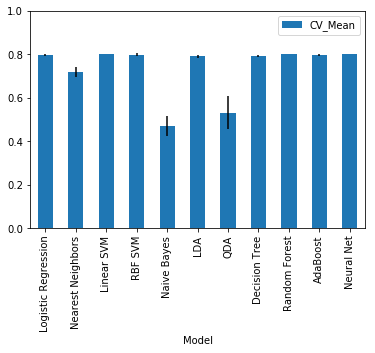

In [23]:
cv.plot(y='CV_Mean', yerr='CV_Std_Dev',kind='bar', ylim=[0, 1])

# Further Illustration on dummy data

The rest of this tutorial shows how to visulaise the different classifiers on dummy data, taken from the [sklearn tutorial](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).  

See if you can update the code to apply to the personality profiles problem statement...

In [24]:
h = .02  # step size in the mesh

In [25]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

In [26]:
datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable,            
            ]

C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\jlesl\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


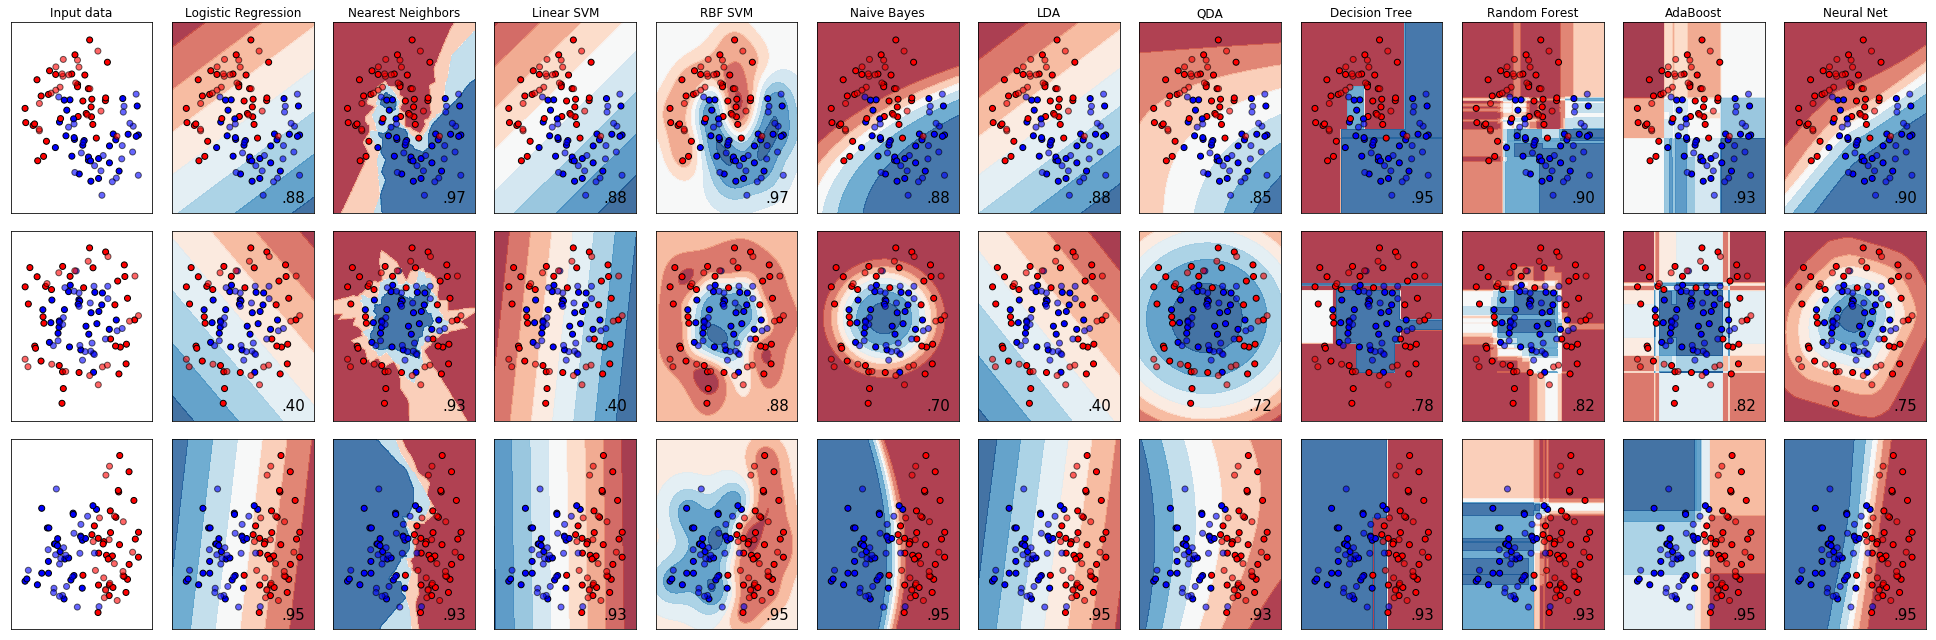

In [27]:
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()